# 20News 

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time

import argparse
import os

%matplotlib inline

2024-08-07 00:06:17.545148: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 00:06:17.609967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
parser = argparse.ArgumentParser()

parser.add_argument('--number_edges', type=int, default=16, help='Graph: minimum number of edges per vertex.')
parser.add_argument('--metric', type=str, default='cosine', help='Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
parser.add_argument('--normalized_laplacian', type=bool, default=True, help='Graph Laplacian: normalized.')
parser.add_argument('--coarsening_levels', type=int, default=0, help='Number of coarsened graphs.')

parser.add_argument('--dir_data', type=str, default=os.path.join('..', 'data', '20news'), help='Directory to store data.')
parser.add_argument('--val_size', type=int, default=400, help='Size of the validation set.')

FLAGS, unparsed = parser.parse_known_args()

print(f'number_edges: {FLAGS.number_edges}')
print(f'metric: {FLAGS.metric}')
print(f'normalized_laplacian: {FLAGS.normalized_laplacian}')
print(f'coarsening_levels: {FLAGS.coarsening_levels}')
print(f'dir_data: {FLAGS.dir_data}')
print(f'val_size: {FLAGS.val_size}')


number_edges: 16
metric: cosine
normalized_laplacian: True
coarsening_levels: 0
dir_data: ../data/20news
val_size: 400


# Les données

In [3]:
# Récupérer le dataset. Scikit-learn effectue déjà un certain nettoyage.
remove = ('headers','footers','quotes')  # (), ('headers') ou ('headers','footers','quotes')
train = utils.Text20News(data_home=FLAGS.dir_data, subset='train', remove=remove)

# Pré-traitement : transformer tout en a-z et espaces.
print(train.show_document(1)[:400])
train.clean_text(num='substitute')

# Analyse / tokenisation : transformer les documents en sacs de mots.
# stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Ou mots vides de NLTK.
train.vectorize(stop_words='english')
print(train.show_document(1)[:400])

N = 11314 documents, C = 20 classes
document 1: label 4 --> comp.sys.mac.hardware, 90 words
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the nex
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  1.00 "adapters" (669)
  2.00 "add" (684)
  1.00 "answered" (2523)
  1.00 "attained" (3941)
  1.00 "base" (5026)
  1.00 "brave" (7179)
  1.00 "brief" (7318)
  1.00 "cards" (8579)
  2.00 "clock" (10473)
  1.00 "cpu" (12728)
  1.00 "day" (14053)
  1.00 "days" (14068)
  1.00 "detailing" (15215)
  1.00 "disk" (16087)
  1.00 "especially" (19550)
  2.00 "experiences" (20279)
  1.00 "fair" (20691)
  1.00 "floppies" (22013)
  1.00 "floppy" (22014)
  1.00

N = 11314 documents, M = 72607 words, sparsity=0.0852%
    480 documents in class  0 (alt.atheism)
    584 documents in class  1 (comp.graphics)
    591 documents in class  2 (comp.os.ms-windows.misc)
    590 documents in class  3 (comp.sys.ibm.pc.hardware)
    578 documents in class  4 (comp.sys.mac.hardware)
    593 documents in class  5 (comp.windows.x)
    585 documents in class  6 (misc.forsale)
    594 documents in class  7 (rec.autos)
    598 documents in class  8 (rec.motorcycles)
    597 documents in class  9 (rec.sport.baseball)
    600 documents in class 10 (rec.sport.hockey)
    595 documents in class 11 (sci.crypt)
    591 documents in class 12 (sci.electronics)
    594 documents in class 13 (sci.med)
    593 documents in class 14 (sci.space)
    599 documents in class 15 (soc.religion.christian)
    546 documents in class 16 (talk.politics.guns)
    564 documents in class 17 (talk.politics.mideast)
    465 documents in class 18 (talk.politics.misc)
    377 documents in cl

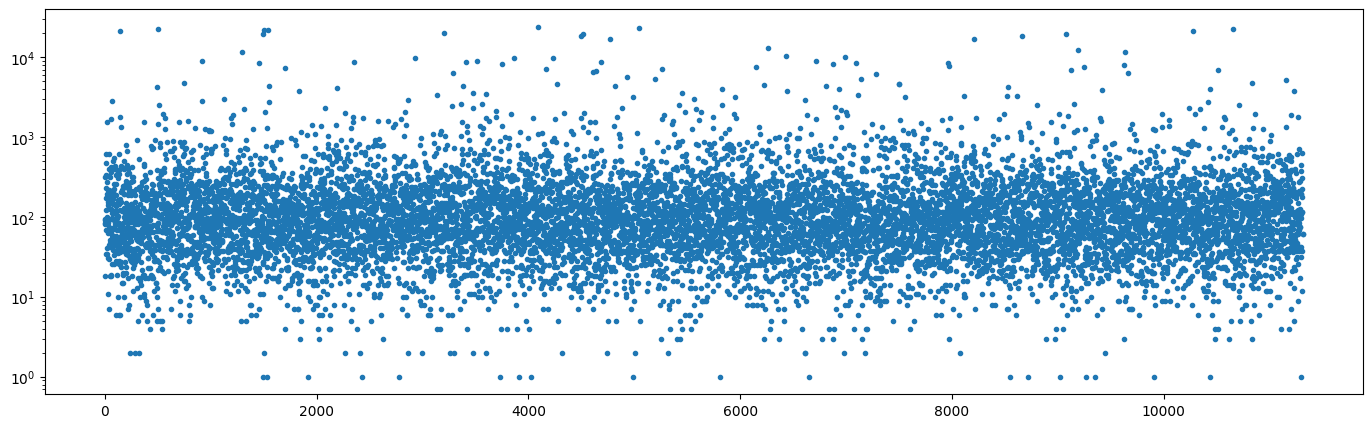

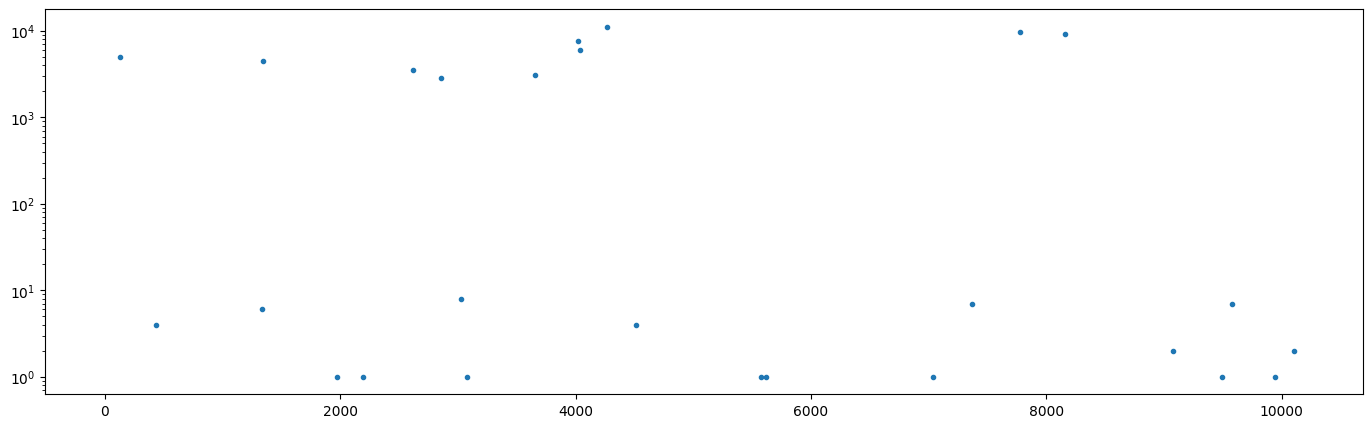

In [4]:
# Supprimer les documents courts.
train.data_info(True)
wc = train.remove_short_documents(nwords=20, vocab='full')
train.data_info()
print('le plus court : {}, le plus long : {} mots'.format(wc.min(), wc.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

# Supprimer les images encodées.
def remove_encoded_images(dataset, freq=1e3):
    # Utiliser np.where pour trouver l'index de 'ax' dans train.vocab
    widx = np.where(train.vocab == 'ax')[0][0]
    wc = train.data[:, widx].toarray().squeeze()
    idx = np.argwhere(wc < freq).squeeze()
    dataset.keep_documents(idx)
    return wc

wc = remove_encoded_images(train)
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');


In [5]:
# Word embedding
if True:
    train.embed()
else:
    train.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))
train.data_info()


53279 words not found in corpus
N = 10171 documents, M = 19328 words, sparsity=0.3141%


most frequent words
    0: num        163934 counts
    1: dollar      10562 counts
    2: people       4093 counts
    3: like         3942 counts
    4: don          3869 counts
    5: just         3721 counts
    6: know         3464 counts
    7: use          3166 counts
    8: think        2995 counts
    9: time         2966 counts
   10: does         2749 counts
   11: new          2606 counts
   12: good         2492 counts
   13: edu          2416 counts
   14: way          2032 counts
   15: make         2022 counts
   16: god          1976 counts
   17: used         1874 counts
   18: ve           1857 counts
   19: say          1841 counts
N = 10171 documents, M = 1000 words, sparsity=2.8349%
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  3.00 "num" (0)
  1.00 "number" (40)
  1.00 "thanks" (48)
  1.00 "day" (76)
  1.00 "send" (97)
  1.00 "disk" (156)
  1.00 "message" (206)
  2.00 "speed" (226)
  1.00 "days" (244)
  1.00 "especially" (384)
  2.00 "add" (437)
  1.0

/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/graph.py:48: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  assert metric is 'cosine'
/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/graph.py:157: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if algo is 'eig':
/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/graph.py:160: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif algo is 'eigh':
/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/graph.py:162: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif algo is 'eigs':
/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/graph.py:165: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif algo is 'eigsh':


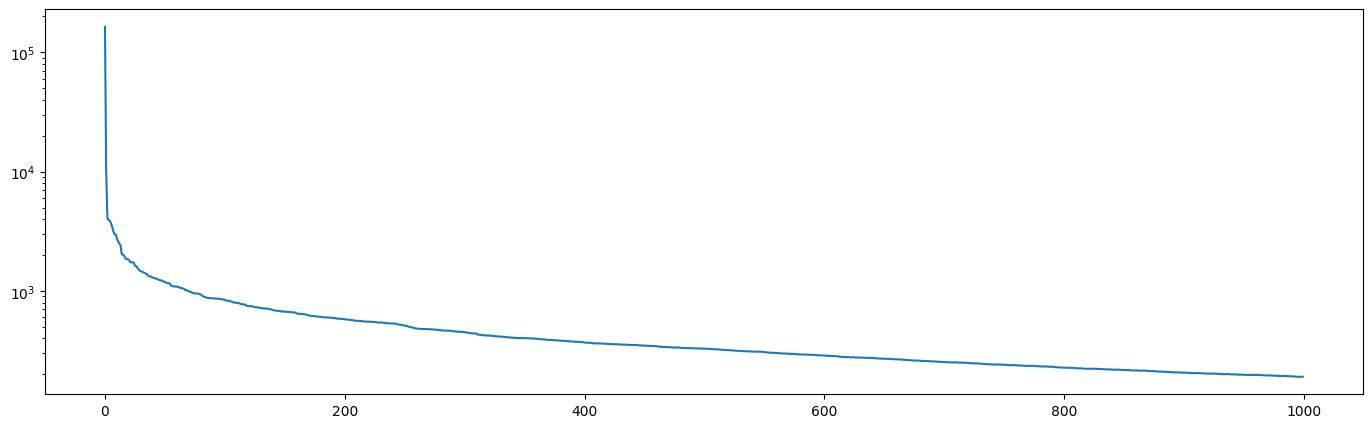

In [6]:
# Sélection de caractéristiques.
# D'autres options incluent : l'information mutuelle ou le nombre de documents.
freq = train.keep_top_words(10000, 20)
train.data_info()
train.show_document(1)
plt.figure(figsize=(17,5))
plt.semilogy(freq);

# Supprimer les documents dont le signal serait le vecteur zéro.
wc = train.remove_short_documents(nwords=5, vocab='selected')
train.data_info(True)


In [7]:
train.normalize(norm='l1')
train.show_document(1);

document 1: label 4 --> comp.sys.mac.hardware, 92 words
  0.13 "num" (0)
  0.04 "number" (40)
  0.04 "thanks" (48)
  0.04 "day" (76)
  0.04 "send" (97)
  0.04 "disk" (156)
  0.04 "message" (206)
  0.09 "speed" (226)
  0.04 "days" (244)
  0.04 "especially" (384)
  0.09 "add" (437)
  0.04 "haven" (469)
  0.04 "network" (529)
  0.04 "cards" (591)
  0.04 "knowledge" (614)
  0.04 "base" (707)
  0.04 "floppy" (755)
  0.09 "clock" (976)


In [8]:
# Test dataset
test = utils.Text20News(data_home=FLAGS.dir_data, subset='test', remove=remove)
test.clean_text(num='substitute')
test.vectorize(vocabulary=train.vocab)
test.data_info()
wc = test.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
test.data_info(True)
test.normalize(norm='l1')

N = 7532 documents, C = 20 classes
N = 7532 documents, M = 1000 words, sparsity=2.4664%
shortest: 0, longest: 23751 words
N = 6694 documents, M = 1000 words, sparsity=2.7533%
    275 documents in class  0 (alt.atheism)
    355 documents in class  1 (comp.graphics)
    358 documents in class  2 (comp.os.ms-windows.misc)
    370 documents in class  3 (comp.sys.ibm.pc.hardware)
    348 documents in class  4 (comp.sys.mac.hardware)
    365 documents in class  5 (comp.windows.x)
    359 documents in class  6 (misc.forsale)
    336 documents in class  7 (rec.autos)
    321 documents in class  8 (rec.motorcycles)
    345 documents in class  9 (rec.sport.baseball)
    350 documents in class 10 (rec.sport.hockey)
    343 documents in class 11 (sci.crypt)
    362 documents in class 12 (sci.electronics)
    345 documents in class 13 (sci.med)
    346 documents in class 14 (sci.space)
    365 documents in class 15 (soc.religion.christian)
    319 documents in class 16 (talk.politics.guns)
    338 

In [9]:
if True:
    train_data = train.data.astype(np.float32)
    test_data = test.data.astype(np.float32)
    train_labels = train.labels
    test_labels = test.labels
else:
    perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
    Ntest = 6695
    perm_test = perm[:Ntest]
    perm_train = perm[Ntest:]
    train_data = train.data[perm_train,:].astype(np.float32)
    test_data = train.data[perm_test,:].astype(np.float32)
    train_labels = train.labels[perm_train]
    test_labels = train.labels[perm_test]

if True:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = train.data.T.astype(np.float32).toarray()

# Feature graph

Permet de calculer les distances entre les nœuds d'un graphe, crée une matrice d'adjacence et remplace les arêtes aléatoires. Ensuite, il applique un algorithme de coarsening pour réduire la taille du graphe. À chaque niveau de coarsening, il calcule les matrices laplaciennes normalisées, tout en mesurant le temps d'exécution. Chaque étape optimise les données du graphe pour une analyse plus efficace et évalue les performances en temps réel.

In [10]:
t_start = time.process_time()
dist, idx = graph.distance_sklearn_metrics(graph_data, k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))

11349 > 8000 edges
Layer 0: M_0 = |V| = 1000 nodes (0 added),|E| = 11349 edges
Execution time: 14.45s


In [11]:
t_start = time.process_time()
train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

Execution time: 0.14s


# Classification : Filtres de Convolution comparés

<h4>Chebyshev (ChebConv) :</h4> 

ChebConv + Softmax : Couche ChebConv suivie de Softmax\
ChebConv + FC + Softmax : ChebConv, couche entièrement connectée (FC), puis Softmax\
ChebConv + FC + FC + Softmax : ChebConv, deux couches FC, puis Softmax\
ChebConv + CGConv + Softmax : ChebConv, CGConv, puis Softmax\
ChebConv + CGConv + FC + Softmax : ChebConv, CGConv, FC, puis Softmax

<h4>Fourier (Non Paramétrique) :</h4>

Fourier + FGConv + Softmax : FGConv suivie de Softmax

<h4>Spline :</h4>

Spline + SGConv + Softmax : SGConv suivie de Softmax



In [12]:
# Training set is shuffled already.
#perm = np.random.permutation(train_data.shape[0])
#train_data = train_data[perm,:]
#train_labels = train_labels[perm]

# Validation set.
if False:
    val_data = train_data[:FLAGS.val_size,:]
    val_labels = train_labels[:FLAGS.val_size]
    train_data = train_data[FLAGS.val_size:,:]
    train_labels = train_labels[FLAGS.val_size:]
else:
    val_data = test_data
    val_labels = test_labels

In [13]:
if True:
    utils.baseline(train_data, train_labels, test_data, test_labels)

/home/G06983/.conda/envs/env_test/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/G06983/.conda/envs/env_test/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Train accuracy:      46.24 55.57 64.39 99.95 71.52 69.83 73.53
Test accuracy:       28.98 46.85 49.15 55.21 54.96 56.56 57.22
Train F1 (weighted): 46.52 53.72 65.10 99.95 70.08 69.03 72.86
Test F1 (weighted):  28.56 44.80 49.64 54.43 52.63 55.19 56.09
Execution time:      178.51 182.73  1.80 14.92  0.02  0.25  0.97


In [14]:
common = {}
common['dir_name']       = '20news/'
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [15]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 1e3
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: logits (softmax)
    representation: M_1 = 20
    weights: M_0 * M_1 = 1000 * 20 = 20000
    biases: M_1 = 20


2024-08-07 00:07:13.710958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:07:13.712729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6
2024-08-07 00:07:13.747881: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


step 400 / 7938 (epoch 4.03 / 80):
  learning_rate = 8.15e+02, loss_average = 2.57e+02
  validation accuracy: 28.43 (1903 / 6694), f1 (weighted): 25.96, loss: 2.84e+02
  time: 3s (wall 4s)
step 800 / 7938 (epoch 8.06 / 80):
  learning_rate = 6.63e+02, loss_average = 4.33e+01
  validation accuracy: 45.62 (3054 / 6694), f1 (weighted): 45.16, loss: 5.90e+01
  time: 4s (wall 6s)
step 1200 / 7938 (epoch 12.09 / 80):
  learning_rate = 5.40e+02, loss_average = 2.46e+01
  validation accuracy: 45.47 (3044 / 6694), f1 (weighted): 45.85, loss: 5.57e+01
  time: 5s (wall 8s)
step 1600 / 7938 (epoch 16.12 / 80):
  learning_rate = 4.40e+02, loss_average = 1.86e+01
  validation accuracy: 51.69 (3460 / 6694), f1 (weighted): 49.87, loss: 4.16e+01
  time: 7s (wall 10s)
step 2000 / 7938 (epoch 20.16 / 80):
  learning_rate = 3.58e+02, loss_average = 9.97e+00
  validation accuracy: 53.17 (3559 / 6694), f1 (weighted): 52.08, loss: 3.63e+01
  time: 8s (wall 13s)
step 2400 / 7938 (epoch 24.19 / 80):
  learning

2024-08-07 00:08:00.157951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:08:00.159465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 88.81 (8813 / 9923), f1 (weighted): 88.81, loss: 2.23e+00
time: 0s (wall 1s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/20news/softmax/model-7938


2024-08-07 00:08:00.691649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:08:00.693190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 55.23 (3697 / 6694), f1 (weighted): 55.30, loss: 2.82e+01
time: 0s (wall 0s)


In [16]:
if True:
    name = 'fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 1000 * 2500 = 2500000
    biases: M_1 = 2500
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 2500 * 20 = 50000
    biases: M_2 = 20


2024-08-07 00:08:01.229439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:08:01.230839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 400 / 7938 (epoch 4.03 / 80):
  learning_rate = 8.15e-02, loss_average = 2.14e+00
  validation accuracy: 41.43 (2773 / 6694), f1 (weighted): 36.63, loss: 2.27e+00
  time: 2s (wall 4s)
step 800 / 7938 (epoch 8.06 / 80):
  learning_rate = 6.63e-02, loss_average = 1.66e+00
  validation accuracy: 48.48 (3245 / 6694), f1 (weighted): 47.51, loss: 1.89e+00
  time: 4s (wall 8s)
step 1200 / 7938 (epoch 12.09 / 80):
  learning_rate = 5.40e-02, loss_average = 1.44e+00
  validation accuracy: 52.38 (3506 / 6694), f1 (weighted): 51.37, loss: 1.73e+00
  time: 6s (wall 11s)
step 1600 / 7938 (epoch 16.12 / 80):
  learning_rate = 4.40e-02, loss_average = 1.30e+00
  validation accuracy: 53.36 (3572 / 6694), f1 (weighted): 52.32, loss: 1.66e+00
  time: 7s (wall 15s)
step 2000 / 7938 (epoch 20.16 / 80):
  learning_rate = 3.58e-02, loss_average = 1.18e+00
  validation accuracy: 54.93 (3677 / 6694), f1 (weighted): 55.94, loss: 1.60e+00
  time: 9s (wall 18s)
step 2400 / 7938 (epoch 24.19 / 80):
  learnin

2024-08-07 00:09:11.837707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:09:11.839370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 75.71 (7513 / 9923), f1 (weighted): 75.23, loss: 9.39e-01
time: 1s (wall 2s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/20news/fc_softmax/model-7938


2024-08-07 00:09:13.474896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:09:13.476313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 57.32 (3837 / 6694), f1 (weighted): 56.74, loss: 1.49e+00
time: 1s (wall 1s)


In [17]:
if True:
    name = 'fc_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, 500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 1000 * 2500 = 2500000
    biases: M_1 = 2500
  layer 2: fc2
    representation: M_2 = 500
    weights: M_1 * M_2 = 2500 * 500 = 1250000
    biases: M_2 = 500
  layer 3: logits (softmax)
    representation: M_3 = 20
    weights: M_2 * M_3 = 500 * 20 = 10000
    biases: M_3 = 20


2024-08-07 00:09:14.797453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:09:14.799082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 400 / 7938 (epoch 4.03 / 80):
  learning_rate = 8.15e-02, loss_average = 1.85e+00
  validation accuracy: 37.65 (2520 / 6694), f1 (weighted): 32.32, loss: 2.04e+00
  time: 3s (wall 4s)
step 800 / 7938 (epoch 8.06 / 80):
  learning_rate = 6.63e-02, loss_average = 1.55e+00
  validation accuracy: 43.01 (2879 / 6694), f1 (weighted): 40.33, loss: 1.83e+00
  time: 5s (wall 7s)
step 1200 / 7938 (epoch 12.09 / 80):
  learning_rate = 5.40e-02, loss_average = 1.17e+00
  validation accuracy: 48.03 (3215 / 6694), f1 (weighted): 45.27, loss: 1.82e+00
  time: 6s (wall 10s)
step 1600 / 7938 (epoch 16.12 / 80):
  learning_rate = 4.40e-02, loss_average = 9.56e-01
  validation accuracy: 48.98 (3279 / 6694), f1 (weighted): 47.94, loss: 1.84e+00
  time: 8s (wall 13s)
step 2000 / 7938 (epoch 20.16 / 80):
  learning_rate = 3.58e-02, loss_average = 8.26e-01
  validation accuracy: 52.00 (3481 / 6694), f1 (weighted): 51.14, loss: 1.74e+00
  time: 10s (wall 16s)
step 2400 / 7938 (epoch 24.19 / 80):
  learni

2024-08-07 00:10:17.585334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:10:17.587030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 93.18 (9246 / 9923), f1 (weighted): 93.14, loss: 3.15e-01
time: 1s (wall 2s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/20news/fc_fc_softmax/model-7938


2024-08-07 00:10:19.162969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:10:19.164429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 56.92 (3810 / 6694), f1 (weighted): 56.75, loss: 1.83e+00
time: 1s (wall 1s)


In [18]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'fourier'
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.001
    params['decay_rate']     = 1
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [L[0].shape[0]]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 1000 = 32000
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 32000 * 20 = 640000
    biases: M_2 = 20


2024-08-07 00:10:35.109871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:10:35.111274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 400 / 7938 (epoch 4.03 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 6.93 (464 / 6694), f1 (weighted): 1.42, loss: 2.99e+00
  time: 1s (wall 3s)
step 800 / 7938 (epoch 8.06 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 6.08 (407 / 6694), f1 (weighted): 2.23, loss: 2.99e+00
  time: 3s (wall 5s)
step 1200 / 7938 (epoch 12.09 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 5.56 (372 / 6694), f1 (weighted): 1.18, loss: 2.99e+00
  time: 4s (wall 7s)
step 1600 / 7938 (epoch 16.12 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 5.12 (343 / 6694), f1 (weighted): 0.50, loss: 2.99e+00
  time: 5s (wall 9s)
step 2000 / 7938 (epoch 20.16 / 80):
  learning_rate = 1.00e-03, loss_average = 2.99e+00
  validation accuracy: 5.68 (380 / 6694), f1 (weighted): 0.94, loss: 2.99e+00
  time: 6s (wall 11s)
step 2400 / 7938 (epoch 24.19 / 80):
  learning_rate = 1.00e-03

2024-08-07 00:11:18.134586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:11:18.136056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 6.67 (662 / 9923), f1 (weighted): 2.70, loss: 3.01e+00
time: 1s (wall 1s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/20news/fgconv_softmax/model-7938


2024-08-07 00:11:18.919479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:11:18.921172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 6.21 (416 / 6694), f1 (weighted): 2.70, loss: 2.99e+00
time: 0s (wall 1s)


In [19]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'spline'
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 5 = 160
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 32000 * 20 = 640000
    biases: M_2 = 20


2024-08-07 00:11:27.061982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:11:27.063382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 400 / 7938 (epoch 4.03 / 80):
  learning_rate = 9.96e-02, loss_average = 5.28e+00
  validation accuracy: 5.50 (368 / 6694), f1 (weighted): 0.69, loss: 5.28e+00
  time: 2s (wall 3s)
step 800 / 7938 (epoch 8.06 / 80):
  learning_rate = 9.92e-02, loss_average = 5.10e+00
  validation accuracy: 5.45 (365 / 6694), f1 (weighted): 0.56, loss: 5.10e+00
  time: 3s (wall 5s)
step 1200 / 7938 (epoch 12.09 / 80):
  learning_rate = 9.88e-02, loss_average = 4.94e+00
  validation accuracy: 5.45 (365 / 6694), f1 (weighted): 0.56, loss: 4.94e+00
  time: 4s (wall 7s)
step 1600 / 7938 (epoch 16.12 / 80):
  learning_rate = 9.84e-02, loss_average = 4.79e+00
  validation accuracy: 5.60 (375 / 6694), f1 (weighted): 0.83, loss: 4.79e+00
  time: 6s (wall 10s)
step 2000 / 7938 (epoch 20.16 / 80):
  learning_rate = 9.80e-02, loss_average = 4.66e+00
  validation accuracy: 5.80 (388 / 6694), f1 (weighted): 1.10, loss: 4.66e+00
  time: 7s (wall 12s)
step 2400 / 7938 (epoch 24.19 / 80):
  learning_rate = 9.76e-0

2024-08-07 00:12:11.051982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:12:11.053397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 36.48 (3620 / 9923), f1 (weighted): 35.57, loss: 3.27e+00
time: 1s (wall 1s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/20news/sgconv_softmax/model-7938


2024-08-07 00:12:11.830313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:12:11.831819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 31.10 (2082 / 6694), f1 (weighted): 30.04, loss: 3.29e+00
time: 0s (wall 1s)


In [20]:
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 32 / 1 = 32000
    weights: F_0 * F_1 * K_1 = 1 * 32 * 5 = 160
    biases: F_1 = 32
  layer 2: logits (softmax)
    representation: M_2 = 20
    weights: M_1 * M_2 = 32000 * 20 = 640000
    biases: M_2 = 20


2024-08-07 00:12:12.537129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:12:12.538514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 400 / 7938 (epoch 4.03 / 80):
  learning_rate = 9.96e-02, loss_average = 5.29e+00
  validation accuracy: 5.54 (371 / 6694), f1 (weighted): 0.88, loss: 5.29e+00
  time: 2s (wall 2s)
step 800 / 7938 (epoch 8.06 / 80):
  learning_rate = 9.92e-02, loss_average = 5.11e+00
  validation accuracy: 6.08 (407 / 6694), f1 (weighted): 1.30, loss: 5.11e+00
  time: 3s (wall 5s)
step 1200 / 7938 (epoch 12.09 / 80):
  learning_rate = 9.88e-02, loss_average = 4.94e+00
  validation accuracy: 8.16 (546 / 6694), f1 (weighted): 3.44, loss: 4.94e+00
  time: 4s (wall 7s)
step 1600 / 7938 (epoch 16.12 / 80):
  learning_rate = 9.84e-02, loss_average = 4.75e+00
  validation accuracy: 9.73 (651 / 6694), f1 (weighted): 4.46, loss: 4.76e+00
  time: 5s (wall 9s)
step 2000 / 7938 (epoch 20.16 / 80):
  learning_rate = 9.80e-02, loss_average = 4.57e+00
  validation accuracy: 12.35 (827 / 6694), f1 (weighted): 7.83, loss: 4.58e+00
  time: 6s (wall 11s)
step 2400 / 7938 (epoch 24.19 / 80):
  learning_rate = 9.76e-0

2024-08-07 00:12:53.945068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:12:53.946701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 78.33 (7773 / 9923), f1 (weighted): 78.19, loss: 1.58e+00
time: 0s (wall 1s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/20news/cgconv_softmax/model-7938


2024-08-07 00:12:54.543886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:12:54.545477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 55.86 (3739 / 6694), f1 (weighted): 55.64, loss: 2.34e+00
time: 0s (wall 1s)


In [21]:
if True:
    name = 'cgconv_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [5]
    params['K']              = [15]
    params['p']              = [1]
    params['M']              = [100, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1000
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1000 * 5 / 1 = 5000
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 5000 * 100 = 500000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 20
    weights: M_2 * M_3 = 100 * 20 = 2000
    biases: M_3 = 20


2024-08-07 00:12:55.263006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:12:55.264412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


step 400 / 7938 (epoch 4.03 / 80):
  learning_rate = 9.96e-02, loss_average = 2.99e+00
  validation accuracy: 7.32 (490 / 6694), f1 (weighted): 2.90, loss: 2.99e+00
  time: 3s (wall 3s)
step 800 / 7938 (epoch 8.06 / 80):
  learning_rate = 9.92e-02, loss_average = 2.96e+00
  validation accuracy: 9.35 (626 / 6694), f1 (weighted): 3.76, loss: 2.96e+00
  time: 4s (wall 6s)
step 1200 / 7938 (epoch 12.09 / 80):
  learning_rate = 9.88e-02, loss_average = 2.88e+00
  validation accuracy: 12.04 (806 / 6694), f1 (weighted): 6.87, loss: 2.89e+00
  time: 5s (wall 9s)
step 1600 / 7938 (epoch 16.12 / 80):
  learning_rate = 9.84e-02, loss_average = 2.79e+00
  validation accuracy: 16.03 (1073 / 6694), f1 (weighted): 11.76, loss: 2.81e+00
  time: 7s (wall 11s)
step 2000 / 7938 (epoch 20.16 / 80):
  learning_rate = 9.80e-02, loss_average = 2.43e+00
  validation accuracy: 25.44 (1703 / 6694), f1 (weighted): 24.73, loss: 2.53e+00
  time: 8s (wall 14s)
step 2400 / 7938 (epoch 24.19 / 80):
  learning_rate = 

2024-08-07 00:13:48.693902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:13:48.695481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


train accuracy: 96.81 (9606 / 9923), f1 (weighted): 96.81, loss: 1.88e-01
time: 1s (wall 2s)
INFO:tensorflow:Restoring parameters from /home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/lib/../checkpoints/20news/cgconv_fc_softmax/model-7938


2024-08-07 00:13:50.345736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1021 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:37:00.0, compute capability: 8.6
2024-08-07 00:13:50.347327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 39562 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:86:00.0, compute capability: 8.6


test  accuracy: 53.05 (3551 / 6694), f1 (weighted): 53.15, loss: 2.61e+00
time: 1s (wall 1s)


  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
53.05 96.81   53.15 96.81   2.61e+00 1.88e-01     7   cgconv_fc_softmax
55.86 78.33   55.64 78.19   2.34e+00 1.58e+00     5   cgconv_softmax
56.92 93.18   56.75 93.14   1.83e+00 3.15e-01     8   fc_fc_softmax
57.32 75.71   56.74 75.23   1.49e+00 9.39e-01     9   fc_softmax
 6.21  6.67    2.70  2.70   2.99e+00 3.01e+00     5   fgconv_softmax
31.10 36.48   30.04 35.57   3.29e+00 3.27e+00     6   sgconv_softmax
55.23 88.81   55.30 88.81   2.82e+01 2.23e+00     6   softmax


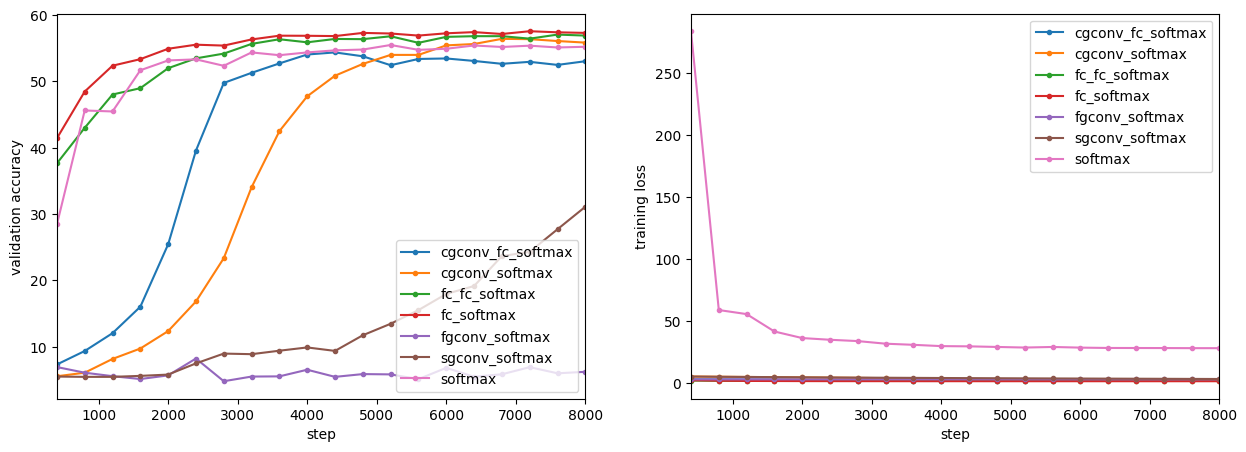

In [22]:
model_perf.show()

In [23]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))